In [1]:
import sqlite3
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
#optimal cluster number evalution function
def optimal_cluster(column_name,df):
    Sum_of_squared_distances = []
    K = range(1,15)
    for k in K:
        km = KMeans(n_clusters=k)
        km = km.fit(df[[column_name]])
        Sum_of_squared_distances.append(km.inertia_)

    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum of squared distances')
    plt.title('Elbow Method For Optimal k ({})'.format(column_name))
    plt.show()

In [3]:
#Ordering Clusters functon
def order_clusters(cluster_pred,column_name,df,asc):
    df_temp=df.groupby(by=cluster_pred)[column_name].mean().reset_index()
    df_temp=df_temp.sort_values(by=column_name,ascending=asc).reset_index(drop=True)
    df_temp['index']=df_temp.index
    df_main=pd.merge(df,df_temp[['index',cluster_pred]],on=cluster_pred)
    df_main = df_main.drop([cluster_pred],axis=1)
    df_main = df_main.rename(columns={"index":cluster_pred})
    
    return df_main


In [4]:
#Data Extraction
con =sqlite3.connect('sample.db')
products=pd.read_sql_query('SELECT * FROM products',con) 
segments=pd.read_sql_query('SELECT * FROM segments',con)
transactions=pd.read_sql_query('SELECT * FROM transactions',con)
segments['update_at']=pd.to_datetime(segments['update_at'])
transactions['trans_dt']=pd.to_datetime(transactions['trans_dt'])
df= pd.read_sql_query('''SELECT transactions.cust_id, seg.seg_name,products.category,(transactions.item_price*transactions.item_qty) AS 'revenue', transactions.trans_dt
    FROM 'transactions'
    LEFT JOIN 'products' ON transactions.prod_id=products.prod_id
    LEFT JOIN (SELECT * 
    FROM (SELECT cust_id, update_at, seg_name 
    FROM 'segments'
    WHERE active_flag ='Y'
    ORDER BY cust_id, update_at DESC)
    GROUP BY cust_id) AS seg ON transactions.cust_id=seg.cust_id
    ORDER BY transactions.cust_id, transactions.prod_id''',con)
df['trans_dt']=pd.to_datetime(df['trans_dt'])

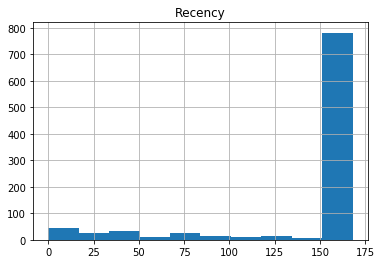

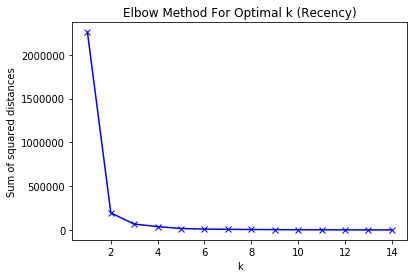

In [5]:
#Recency Analysis
max_purchase_date=df.groupby(by='cust_id').agg(MaxDate=('trans_dt','max'))
max_purchase_date['Recency']=(max_purchase_date['MaxDate'].max()-max_purchase_date['MaxDate']).dt.days
main=max_purchase_date.reset_index()
main.hist(column='Recency')#Histogram of Recency
plt.figure()
optimal_cluster('Recency',main)
main['RecencyClusters']=KMeans(n_clusters=4).fit_predict(main[['Recency']])
main= order_clusters('RecencyClusters','Recency',main,False)

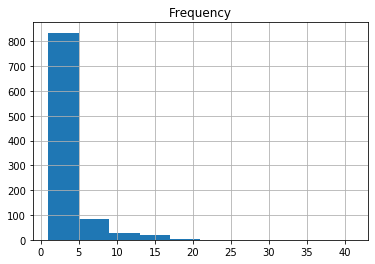

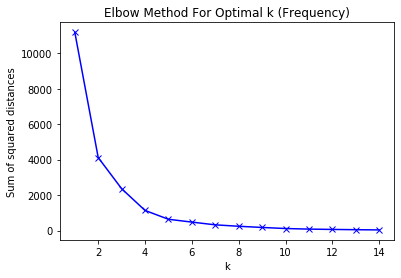

In [6]:
#Frequency Analysis
customer_freq=df.groupby(by='cust_id').agg(Frequency=('trans_dt','count'))
main=pd.merge(main,customer_freq[['Frequency']],on='cust_id')
main.hist(column='Frequency') #Histogram of Recency
plt.figure()
optimal_cluster('Frequency',main)
main['FreqClusters']=KMeans(n_clusters=4).fit_predict(main[['Frequency']])
main=order_clusters('FreqClusters','Frequency',main,True)

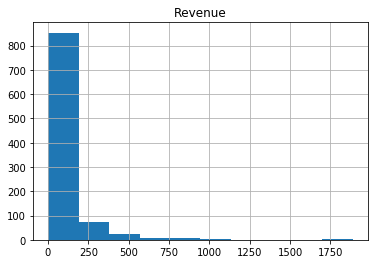

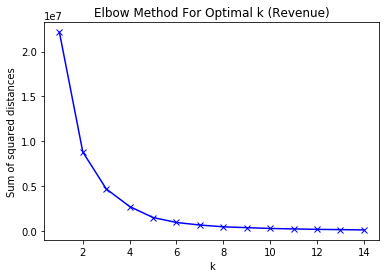

In [7]:
#Reveneue Analysis
customer_rev=df.groupby(by='cust_id').agg(Revenue=('revenue','sum'))
main=pd.merge(main,customer_rev[['Revenue']],on='cust_id')
main.hist(column='Revenue') #Histogram of Recency
plt.figure()
optimal_cluster('Revenue',main)
main['RevClusters']=KMeans(n_clusters=4).fit_predict(main[['Revenue']])
main=order_clusters('RevClusters','Revenue',main,True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000026D61F7E9C8>]],
      dtype=object)

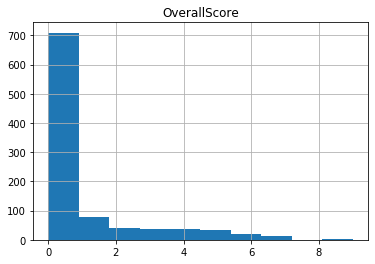

In [8]:
#calculate overall score and use mean() to see details
main['OverallScore'] = main['RecencyClusters'] + main['FreqClusters'] + main['RevClusters']
main.hist(column='OverallScore')

In [9]:
#RFM Categorizing
main['cust_categ'] = 'Low-Value'
main.loc[main['OverallScore']>2,'cust_categ'] = 'Mid-Value' 
main.loc[main['OverallScore']>5,'cust_categ'] = 'High-Value' 

Text(0, 0.5, 'No. of Customers')

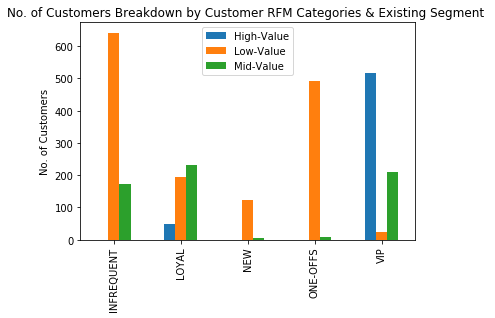

In [10]:
#Analysis of Existing Customer Segment with new Customer Categories
seg_test=pd.merge(main,df[['cust_id','seg_name']], on='cust_id')
group_seg_test=pd.pivot_table(seg_test, values='cust_id', index='seg_name', columns='cust_categ',aggfunc='count')
group_seg_test.columns.name = None 
group_seg_test=group_seg_test.reset_index()
ax1=group_seg_test.plot.bar(x='seg_name', y=group_seg_test.drop(['seg_name'], axis=1).columns.values,title='No. of Customers Breakdown by Customer RFM Categories & Existing Segment ')
ax1.set_xlabel('')
ax1.set_ylabel('No. of Customers')

Text(0, 0.5, 'Revenue($)')

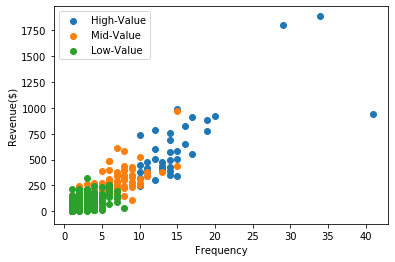

In [11]:
# (EXTRA) Revenue vs. Frequency
group=['High-Value','Mid-Value','Low-Value']
for name in group:
    plt.scatter(main.query('cust_categ==@name')['Frequency'], main.query('cust_categ==@name')['Revenue'], marker='o',label=name)
plt.legend()
plt.xlabel('Frequency')
plt.ylabel('Revenue($)')

Text(0, 0.5, 'Recency (days)')

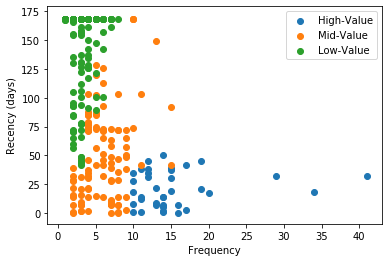

In [12]:
# (EXTRA)Recency vs. Frequency 
for name in group:
    plt.scatter(main.query('cust_categ==@name')['Frequency'], main.query('cust_categ==@name')['Recency'], marker='o',label=name)
plt.legend()
plt.xlabel('Frequency')
plt.ylabel('Recency (days)')

Text(0, 0.5, 'Revenue($)')

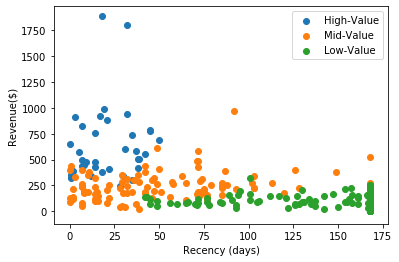

In [13]:
# (EXTRA)Revenue vs. Recency 
for name in group:
    plt.scatter(main.query('cust_categ==@name')['Recency'], main.query('cust_categ==@name')['Revenue'], marker='o',label=name)
plt.legend()
plt.xlabel('Recency (days)')
plt.ylabel('Revenue($)')

Text(0.5, 0, 'Recency(days)')

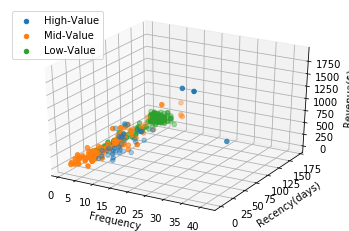

In [14]:
#3d plot of Revenue vs. Recency vs. Freq
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for name in group:
     ax.scatter(main.query('cust_categ==@name')['Frequency'],main.query('cust_categ==@name')['Recency'],main.query('cust_categ==@name')['Revenue'],label=name)
ax.legend(loc=2)
ax.set_xlabel('Frequency')
ax.set_zlabel('Revenue($)')
ax.set_ylabel('Recency(days)')
 

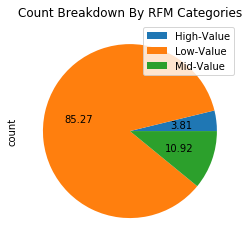

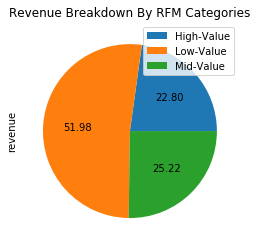

In [15]:
#Count and Total Revenue of High,Medium, low Value Customers
count= main.groupby('cust_categ').agg(count=('cust_id','count'),revenue=('Revenue','sum'))
ax2=count.plot.pie(y='count',autopct='%.2f',labels=None, title='Count Breakdown By RFM Categories')
ax3=count.plot.pie(y='revenue',autopct='%.2f',labels=None, title='Revenue Breakdown By RFM Categories')